In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 10.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer

In [4]:
df = pd.read_csv("wine_with_good_counts.csv")
df["description"] = df["description"].str.lower()
df["variety"].value_counts()


Pinot Noir            8378
Cabernet Sauvignon    8127
Chardonnay            8108
Riesling              3274
Merlot                3111
Malbec                1582
Sangiovese            1414
Zinfandel             1224
Name: variety, dtype: int64

In [5]:
# define the number of observations you want for each grape variety
n_pinot_noir = 5888
n_chardonnay = 5633
n_cabernet_sauvignon = 4405
Riesling=2820
Merlot=2209
Malbec=1263
Zinfandel=940
Sangiovese=790
# filter the DataFrame to only keep the desired number of observations for each grape variety
df_filtered = pd.concat([
    df[df['variety'] == 'Pinot Noir'].sample(n_pinot_noir, random_state=42),
    df[df['variety'] == 'Chardonnay'].sample(n_chardonnay, random_state=42),
    df[df['variety'] == 'Cabernet Sauvignon'].sample(n_cabernet_sauvignon, random_state=42),
    df[df['variety'] == 'Riesling'].sample(Riesling, random_state=42),
    df[df['variety'] == 'Merlot'].sample(Merlot, random_state=42),
    df[df['variety'] == 'Malbec'].sample(Malbec, random_state=42),
    df[df['variety'] == 'Zinfandel'].sample(Zinfandel, random_state=42),
    df[df['variety'] == 'Sangiovese'].sample(Sangiovese, random_state=42),
    
])

# reset the index of the filtered DataFrame
df = df_filtered.reset_index(drop=True)
df["variety"].value_counts()

Pinot Noir            5888
Chardonnay            5633
Cabernet Sauvignon    4405
Riesling              2820
Merlot                2209
Malbec                1263
Zinfandel              940
Sangiovese             790
Name: variety, dtype: int64

In [6]:
stop_variety = list(np.unique(df.variety.dropna().str.lower().tolist()))
stop_words =  stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop = stop_words + stop_append + stop_variety

In [7]:
df["description"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))


0        among well-differentiated single vineyard sele...
1        dark, spicy wood aromas, pass palate. huge pow...
2        excellent pinot noir that's consistent talisma...
3        icon pinot noirs years, one shows fair amount ...
4        here's delicately structured, elegant pinot mo...
                               ...                        
23943    light fruit, milk chocolate nose palate, yield...
23944    dark, ruby-colored generous sharp blackberry b...
23945    chalky dry nose, notes mineral forest berry, s...
23946    charred earth, toast, ground pepper, mature bl...
23947    crafted five estate lots, vino noceto's riserv...
Name: description, Length: 23948, dtype: object

In [8]:
df.head()

,description,variety
0,among the well-differentiated single vineyard ...,Pinot Noir
1,"dark, spicy wood aromas, which pass through to...",Pinot Noir
2,an excellent pinot noir that's consistent with...,Pinot Noir
3,as all the icon pinot noirs have over the year...,Pinot Noir
4,"here's a delicately structured, elegant pinot ...",Pinot Noir


In [9]:
df = df.dropna()
le = LabelEncoder()
df['variety_enc'] = le.fit_transform(df['variety'])
df.head()

,description,variety,variety_enc
0,among the well-differentiated single vineyard ...,Pinot Noir,4
1,"dark, spicy wood aromas, which pass through to...",Pinot Noir,4
2,an excellent pinot noir that's consistent with...,Pinot Noir,4
3,as all the icon pinot noirs have over the year...,Pinot Noir,4
4,"here's a delicately structured, elegant pinot ...",Pinot Noir,4


In [10]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['variety_enc'], test_size=0.2, random_state=42)

In [11]:
#Compute class_weights
class_weights = {}
for i in range(len(np.unique(y_train))):
    class_weights[i] = 1 / 8

print(class_weights)

{0: 0.125, 1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125, 6: 0.125, 7: 0.125}


In [12]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [13]:
print(tokenizer("Hello world")['input_ids'])

[0, 31414, 232, 2]


In [14]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

In [16]:
print(len(np.unique(y_test)))
print(len(np.unique(y_train)))

8
8


In [ ]:
# Configure the BERT model
config = BertConfig.from_pretrained('roberta-base', num_labels=len(np.unique(y_train)))
print(config)


In [18]:
model = TFBertForSequenceClassification.from_pretrained('roberta-base', config=config)

Some layers from the model checkpoint at roberta-base were not used when initializing TFBertForSequenceClassification: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [20]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [21]:
history = model.fit(train_dataset,
                    epochs=1,
                    validation_data=test_dataset,
                    callbacks=[es],
                    class_weight=class_weights)

599/599 [==============================] - 743s 1s/step - loss: 0.1572 - sparse_categorical_accuracy: 0.5281 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.7639


In [25]:
# Load the test data and encode it with the same tokenizer used for training
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)
test_labels = y_test

# Create a TensorFlow Dataset from the encoded test data and labels
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(32)
print(test_dataset)



<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 198), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [38]:
# Make predictions on test dataset
predictions = model.predict(test_dataset)
print(predictions)


150/150 [==============================] - 65s 435ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[-1.4299741 ,  4.5679874 , -1.0538737 , ...,  3.0492642 ,
        -1.5449452 , -1.2112356 ],
       [ 1.4318388 , -3.5455647 ,  0.03369061, ..., -3.0608706 ,
         0.91677207,  0.30485976],
       [-1.6009464 ,  3.369074  , -1.1806145 , ...,  4.6654463 ,
        -1.3034933 , -1.2894737 ],
       ...,
       [-1.474686  ,  3.647714  , -1.0070302 , ...,  4.343818  ,
        -1.4126105 , -1.3105092 ],
       [-1.0251409 ,  1.9093121 , -0.97209525, ...,  3.4082367 ,
        -0.5102696 , -1.9667561 ],
       [ 3.346796  , -2.4512327 ,  1.7500148 , ..., -2.762008  ,
         0.169108  , -0.08632652]], dtype=float32), hidden_states=None, attentions=None)


In [40]:
logits = predictions.logits
# Get the predicted labels
label_list = [0,1,2,3,4,5,6,7]
predicted_labels = tf.argmax(logits, axis=-1).numpy()
predicted_labels = [label_list[label] for label in predicted_labels]

# Print the classification report
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       884
           1       0.89      0.90      0.89      1139
           2       0.53      0.50      0.52       256
           3       0.85      0.48      0.61       436
           4       0.77      0.87      0.82      1187
           5       0.72      0.84      0.78       545
           6       0.00      0.00      0.00       168
           7       0.84      0.55      0.67       175

    accuracy                           0.76      4790
   macro avg       0.66      0.62      0.63      4790
weighted avg       0.74      0.76      0.75      4790



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


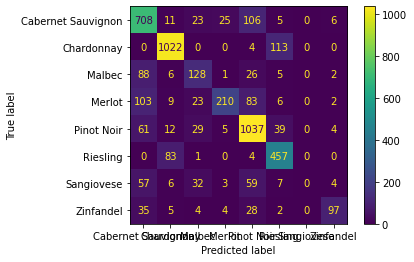

In [42]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_test,predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Cabernet Sauvignon" , "Chardonnay","Malbec","Merlot","Pinot Noir","Riesling","Sangiovese","Zinfandel"])

cm_display.plot()
plt.show()